# March Machine Learning Mania 2026
## Pipeline complet : EDA -> Features -> Modèles -> Soumission

**Stratégie** : Ensemble (Régression Logistique + XGBoost) avec calibration Platt, modèles séparés Hommes/Femmes.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted')

DATA_DIR = Path('march-machine-learning-mania-2026')
print('Fichiers disponibles :')
for f in sorted(DATA_DIR.glob('*.csv')):
    print(f'  {f.name:45s} ({f.stat().st_size / 1024:,.0f} Ko)')

Fichiers disponibles :
  Cities.csv                                    (10 Ko)
  Conferences.csv                               (2 Ko)
  MConferenceTourneyGames.csv                   (175 Ko)
  MGameCities.csv                               (2,854 Ko)
  MMasseyOrdinals.csv                           (123,821 Ko)
  MNCAATourneyCompactResults.csv                (76 Ko)
  MNCAATourneyDetailedResults.csv               (142 Ko)
  MNCAATourneySeedRoundSlots.csv                (16 Ko)
  MNCAATourneySeeds.csv                         (39 Ko)
  MNCAATourneySlots.csv                         (51 Ko)
  MRegularSeasonCompactResults.csv              (5,633 Ko)
  MRegularSeasonDetailedResults.csv             (11,927 Ko)
  MSeasons.csv                                  (2 Ko)
  MSecondaryTourneyCompactResults.csv           (62 Ko)
  MSecondaryTourneyTeams.csv                    (28 Ko)
  MTeamCoaches.csv                              (405 Ko)
  MTeamConferences.csv                          (232 Ko)
  MTeams

In [21]:
# --- Chargement des données ---
m_teams = pd.read_csv(DATA_DIR / 'MTeams.csv')
w_teams = pd.read_csv(DATA_DIR / 'WTeams.csv')
m_seasons = pd.read_csv(DATA_DIR / 'MSeasons.csv')
w_seasons = pd.read_csv(DATA_DIR / 'WSeasons.csv')

m_reg_compact = pd.read_csv(DATA_DIR / 'MRegularSeasonCompactResults.csv')
w_reg_compact = pd.read_csv(DATA_DIR / 'WRegularSeasonCompactResults.csv')
m_reg_detail = pd.read_csv(DATA_DIR / 'MRegularSeasonDetailedResults.csv')
w_reg_detail = pd.read_csv(DATA_DIR / 'WRegularSeasonDetailedResults.csv')

m_tourney = pd.read_csv(DATA_DIR / 'MNCAATourneyCompactResults.csv')
w_tourney = pd.read_csv(DATA_DIR / 'WNCAATourneyCompactResults.csv')
m_tourney_detail = pd.read_csv(DATA_DIR / 'MNCAATourneyDetailedResults.csv')
w_tourney_detail = pd.read_csv(DATA_DIR / 'WNCAATourneyDetailedResults.csv')

m_seeds = pd.read_csv(DATA_DIR / 'MNCAATourneySeeds.csv')
w_seeds = pd.read_csv(DATA_DIR / 'WNCAATourneySeeds.csv')

m_massey = pd.read_csv(DATA_DIR / 'MMasseyOrdinals.csv')

m_coaches = pd.read_csv(DATA_DIR / 'MTeamCoaches.csv')
conferences = pd.read_csv(DATA_DIR / 'Conferences.csv')
m_team_conf = pd.read_csv(DATA_DIR / 'MTeamConferences.csv')
w_team_conf = pd.read_csv(DATA_DIR / 'WTeamConferences.csv')

sub_stage1 = pd.read_csv(DATA_DIR / 'SampleSubmissionStage1.csv')
sub_stage2 = pd.read_csv(DATA_DIR / 'SampleSubmissionStage2.csv')

print(f'Hommes : {len(m_teams)} équipes, {len(m_reg_compact):,} matchs saison rég., {len(m_tourney):,} matchs tournoi')
print(f'Femmes : {len(w_teams)} équipes, {len(w_reg_compact):,} matchs saison rég., {len(w_tourney):,} matchs tournoi')
print(f'Massey ordinals : {len(m_massey):,} lignes, {m_massey["SystemName"].nunique()} systèmes')
print(f'Soumission Stage1 : {len(sub_stage1):,} paires | Stage2 : {len(sub_stage2):,} paires')

Hommes : 381 équipes, 196,823 matchs saison rég., 2,585 matchs tournoi
Femmes : 379 équipes, 140,825 matchs saison rég., 1,717 matchs tournoi
Massey ordinals : 5,761,702 lignes, 196 systèmes
Soumission Stage1 : 519,144 paires | Stage2 : 132,133 paires


---
## 1. EDA — Exploration des Données

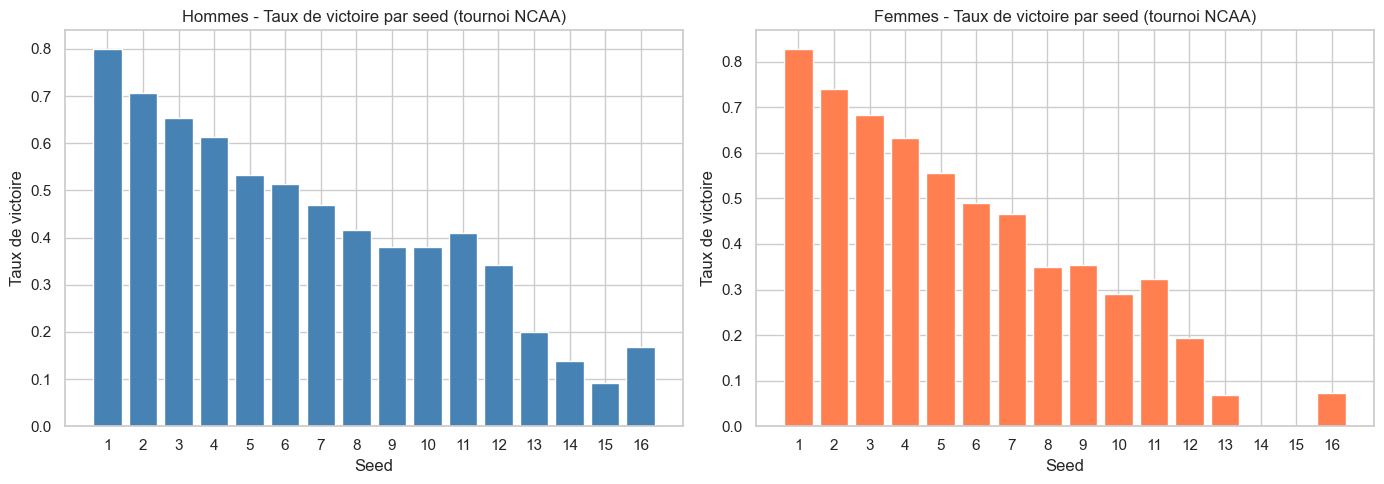

Taux d'upsets (Hommes) : 27.3%
Taux d'upsets (Femmes) : 21.1%


In [22]:
# Distribution des seeds et taux de victoire historique par seed (Hommes)
def parse_seed_num(seed_str):
    """Extrait le numéro de seed (1-16) depuis 'W01', 'X16a', etc."""
    return int(seed_str[1:3])

m_seeds['SeedNum'] = m_seeds['Seed'].apply(parse_seed_num)
w_seeds['SeedNum'] = w_seeds['Seed'].apply(parse_seed_num)

# Joindre les seeds aux résultats du tournoi
def add_seeds_to_tourney(tourney_df, seeds_df):
    df = tourney_df.merge(seeds_df[['Season', 'TeamID', 'SeedNum']],
                          left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
    df = df.rename(columns={'SeedNum': 'WSeed'}).drop(columns='TeamID')
    df = df.merge(seeds_df[['Season', 'TeamID', 'SeedNum']],
                  left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
    df = df.rename(columns={'SeedNum': 'LSeed'}).drop(columns='TeamID')
    return df

m_tourney_seeds = add_seeds_to_tourney(m_tourney, m_seeds)
w_tourney_seeds = add_seeds_to_tourney(w_tourney, w_seeds)

# Taux de victoire par seed
def seed_winrate(df, label):
    records = []
    for _, row in df.iterrows():
        records.append({'Seed': row['WSeed'], 'Won': 1})
        records.append({'Seed': row['LSeed'], 'Won': 0})
    sr = pd.DataFrame(records).groupby('Seed')['Won'].mean()
    return sr

m_wr = seed_winrate(m_tourney_seeds, 'Hommes')
w_wr = seed_winrate(w_tourney_seeds, 'Femmes')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(m_wr.index, m_wr.values, color='steelblue')
axes[0].set_xlabel('Seed'); axes[0].set_ylabel('Taux de victoire')
axes[0].set_title('Hommes - Taux de victoire par seed (tournoi NCAA)')
axes[0].set_xticks(range(1, 17))

axes[1].bar(w_wr.index, w_wr.values, color='coral')
axes[1].set_xlabel('Seed'); axes[1].set_ylabel('Taux de victoire')
axes[1].set_title('Femmes - Taux de victoire par seed (tournoi NCAA)')
axes[1].set_xticks(range(1, 17))
plt.tight_layout()
plt.show()

# Upsets : seed faible bat seed forte
m_tourney_seeds['Upset'] = m_tourney_seeds['WSeed'] > m_tourney_seeds['LSeed']
print(f"Taux d'upsets (Hommes) : {m_tourney_seeds['Upset'].mean():.1%}")
w_tourney_seeds['Upset'] = w_tourney_seeds['WSeed'] > w_tourney_seeds['LSeed']
print(f"Taux d'upsets (Femmes) : {w_tourney_seeds['Upset'].mean():.1%}")

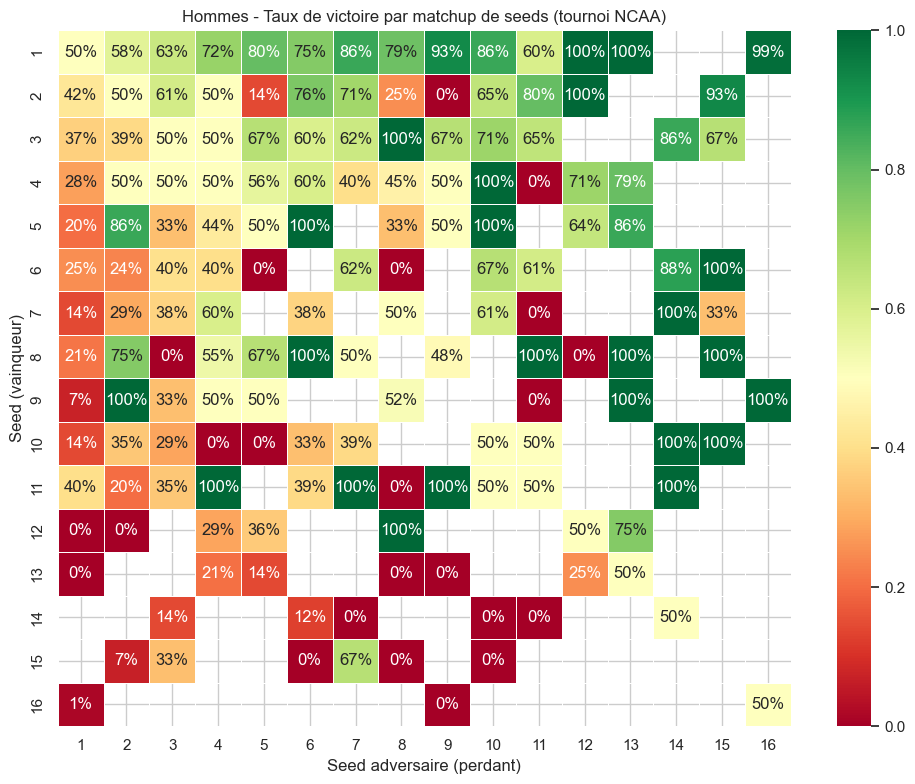

In [23]:
# Matrice de victoire par matchup de seeds (Hommes)
def seed_matchup_matrix(df):
    wins = df.groupby(['WSeed', 'LSeed']).size().reset_index(name='Wins')
    losses = df.groupby(['LSeed', 'WSeed']).size().reset_index(name='Losses')
    losses.columns = ['SeedA', 'SeedB', 'Losses']
    wins.columns = ['SeedA', 'SeedB', 'Wins']
    merged = wins.merge(losses, on=['SeedA', 'SeedB'], how='outer').fillna(0)
    merged['WinRate'] = merged['Wins'] / (merged['Wins'] + merged['Losses'])
    matrix = merged.pivot(index='SeedA', columns='SeedB', values='WinRate')
    return matrix

m_matrix = seed_matchup_matrix(m_tourney_seeds)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(m_matrix, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax,
            vmin=0, vmax=1, linewidths=0.5)
ax.set_title('Hommes - Taux de victoire par matchup de seeds (tournoi NCAA)')
ax.set_xlabel('Seed adversaire (perdant)'); ax.set_ylabel('Seed (vainqueur)')
plt.tight_layout()
plt.show()

---
## 2. Feature Engineering

In [24]:
# =============================================================
# 2.1 — Système ELO
# =============================================================

def compute_elo_ratings(compact_results, k=20, home_adv=100, mean_revert=0.75):
    """
    Calcule les ratings Elo pour toutes les équipes sur toutes les saisons.
    Retourne un dict {(Season, TeamID): elo_rating} avec le rating de fin de saison régulière.
    """
    elo = {}  # TeamID -> current elo
    season_elo = {}  # (Season, TeamID) -> elo at end of regular season
    
    sorted_games = compact_results.sort_values(['Season', 'DayNum']).reset_index(drop=True)
    prev_season = None
    
    for _, row in sorted_games.iterrows():
        season = row['Season']
        
        # Nouvelle saison : réversion vers la moyenne
        if season != prev_season:
            if prev_season is not None:
                # Sauvegarder les elo de fin de saison précédente
                for tid, e in elo.items():
                    season_elo[(prev_season, tid)] = e
                # Mean reversion
                for tid in elo:
                    elo[tid] = 1500 + mean_revert * (elo[tid] - 1500)
            prev_season = season
        
        w_id, l_id = row['WTeamID'], row['LTeamID']
        w_loc = row.get('WLoc', 'N')
        
        # Initialiser si nouvelle équipe
        if w_id not in elo: elo[w_id] = 1500
        if l_id not in elo: elo[l_id] = 1500
        
        w_elo = elo[w_id]
        l_elo = elo[l_id]
        
        # Avantage domicile
        if w_loc == 'H':
            w_elo += home_adv
        elif w_loc == 'A':
            l_elo += home_adv
        
        # Probabilité attendue
        exp_w = 1.0 / (1.0 + 10.0 ** ((l_elo - w_elo) / 400.0))
        
        # Mise à jour
        elo[w_id] += k * (1 - exp_w)
        elo[l_id] -= k * (1 - exp_w)
    
    # Sauvegarder la dernière saison
    for tid, e in elo.items():
        season_elo[(prev_season, tid)] = e
    
    return season_elo

print('Calcul Elo hommes...')
m_elo = compute_elo_ratings(m_reg_compact)
print(f'  -> {len(m_elo):,} paires (saison, équipe)')

print('Calcul Elo femmes...')
w_elo = compute_elo_ratings(w_reg_compact)
print(f'  -> {len(w_elo):,} paires (saison, équipe)')

# Vérification : top 10 Elo hommes saison 2025
top_2025 = {k: v for k, v in m_elo.items() if k[0] == 2025}
top_2025 = sorted(top_2025.items(), key=lambda x: x[1], reverse=True)[:10]
print('\nTop 10 Elo Hommes 2025 :')
for (s, tid), e in top_2025:
    name = m_teams.loc[m_teams['TeamID'] == tid, 'TeamName'].values[0]
    print(f'  {name:20s} : {e:.0f}')

Calcul Elo hommes...
  -> 14,206 paires (saison, équipe)
Calcul Elo femmes...
  -> 9,952 paires (saison, équipe)

Top 10 Elo Hommes 2025 :
  Houston              : 1841
  Duke                 : 1789
  Auburn               : 1779
  Florida              : 1771
  Drake                : 1766
  St Mary's CA         : 1748
  Tennessee            : 1748
  Memphis              : 1744
  Alabama              : 1742
  St John's            : 1742


In [25]:
# =============================================================
# 2.2 — Rankings Massey composites (Hommes uniquement)
# =============================================================

# Sélection des meilleurs systèmes de classement
TOP_SYSTEMS = ['POM', 'SAG', 'MOR', 'WLK', 'DOL', 'COL', 'RPI', 'AP', 'USA', 'NET']

# Filtrer sur les rankings de fin de saison (DayNum >= 128) et les meilleurs systèmes
available_systems = m_massey['SystemName'].unique()
systems_to_use = [s for s in TOP_SYSTEMS if s in available_systems]
print(f'Systèmes disponibles parmi la sélection : {systems_to_use}')

m_massey_late = m_massey[
    (m_massey['RankingDayNum'] >= 128) &
    (m_massey['SystemName'].isin(systems_to_use))
].copy()

# Prendre le ranking le plus récent pour chaque (Season, SystemName, TeamID)
m_massey_latest = (
    m_massey_late
    .sort_values('RankingDayNum')
    .groupby(['Season', 'SystemName', 'TeamID'])
    .last()
    .reset_index()
)

# Calculer le rang moyen composite par (Season, TeamID)
m_massey_composite = (
    m_massey_latest
    .groupby(['Season', 'TeamID'])['OrdinalRank']
    .mean()
    .reset_index()
    .rename(columns={'OrdinalRank': 'MasseyComposite'})
)

print(f'Rankings composites calculés : {len(m_massey_composite):,} entrées')
print(f'Saisons couvertes : {m_massey_composite["Season"].min()} - {m_massey_composite["Season"].max()}')

# Vérification : top 10 composite 2025
top_comp = m_massey_composite[m_massey_composite['Season'] == 2025].nsmallest(10, 'MasseyComposite')
top_comp = top_comp.merge(m_teams[['TeamID', 'TeamName']], on='TeamID')
print('\nTop 10 Massey Composite Hommes 2025 :')
for _, row in top_comp.iterrows():
    print(f'  {row["TeamName"]:20s} : rang moyen {row["MasseyComposite"]:.1f}')

Systèmes disponibles parmi la sélection : ['POM', 'SAG', 'MOR', 'WLK', 'DOL', 'COL', 'RPI', 'AP', 'USA', 'NET']
Rankings composites calculés : 7,980 entrées
Saisons couvertes : 2003 - 2025

Top 10 Massey Composite Hommes 2025 :
  Duke                 : rang moyen 2.0
  Auburn               : rang moyen 2.6
  Florida              : rang moyen 2.7
  Houston              : rang moyen 3.2
  Alabama              : rang moyen 5.6
  Tennessee            : rang moyen 5.7
  Michigan St          : rang moyen 7.9
  St John's            : rang moyen 8.1
  Texas Tech           : rang moyen 12.7
  Wisconsin            : rang moyen 13.7


In [26]:
# =============================================================
# 2.3 — Statistiques d'équipe agrégées (4 Facteurs de Dean Oliver)
# =============================================================

def compute_team_stats(detail_df):
    """
    Calcule les stats agrégées par équipe/saison depuis les résultats détaillés.
    Retourne un DataFrame avec les 4 facteurs de Dean Oliver + stats supplémentaires.
    """
    records = []
    
    # Stats côté vainqueur
    for prefix, team_col, opp_prefix in [('W', 'WTeamID', 'L'), ('L', 'LTeamID', 'W')]:
        df = detail_df.copy()
        
        # Possessions estimées
        df['Poss'] = df[f'{prefix}FGA'] - df[f'{prefix}OR'] + df[f'{prefix}TO'] + 0.475 * df[f'{prefix}FTA']
        df['OppPoss'] = df[f'{opp_prefix}FGA'] - df[f'{opp_prefix}OR'] + df[f'{opp_prefix}TO'] + 0.475 * df[f'{opp_prefix}FTA']
        
        # 4 Facteurs offensifs
        df['eFGpct'] = (df[f'{prefix}FGM'] + 0.5 * df[f'{prefix}FGM3']) / df[f'{prefix}FGA']
        df['TOVpct'] = df[f'{prefix}TO'] / df['Poss']
        df['ORBpct'] = df[f'{prefix}OR'] / (df[f'{prefix}OR'] + df[f'{opp_prefix}DR'])
        df['FTr'] = df[f'{prefix}FTM'] / df[f'{prefix}FGA']
        
        # 4 Facteurs défensifs (de l'adversaire)
        df['Opp_eFGpct'] = (df[f'{opp_prefix}FGM'] + 0.5 * df[f'{opp_prefix}FGM3']) / df[f'{opp_prefix}FGA']
        df['Opp_TOVpct'] = df[f'{opp_prefix}TO'] / df['OppPoss']
        df['Opp_ORBpct'] = df[f'{opp_prefix}OR'] / (df[f'{opp_prefix}OR'] + df[f'{prefix}DR'])
        df['Opp_FTr'] = df[f'{opp_prefix}FTM'] / df[f'{opp_prefix}FGA']
        
        # Score et marge
        df['Score'] = df[f'{prefix}Score'] if f'{prefix}Score' in df.columns else 0
        df['OppScore'] = df[f'{opp_prefix}Score'] if f'{opp_prefix}Score' in df.columns else 0
        df['Won'] = 1 if prefix == 'W' else 0
        
        sub = df[['Season', team_col, 'eFGpct', 'TOVpct', 'ORBpct', 'FTr',
                   'Opp_eFGpct', 'Opp_TOVpct', 'Opp_ORBpct', 'Opp_FTr',
                   f'{prefix}Score', f'{opp_prefix}Score', 'Won']].copy()
        sub.columns = ['Season', 'TeamID', 'eFGpct', 'TOVpct', 'ORBpct', 'FTr',
                        'Opp_eFGpct', 'Opp_TOVpct', 'Opp_ORBpct', 'Opp_FTr',
                        'Score', 'OppScore', 'Won']
        records.append(sub)
    
    all_games = pd.concat(records, ignore_index=True)
    all_games['Margin'] = all_games['Score'] - all_games['OppScore']
    
    # Agréger par (Season, TeamID)
    stats = all_games.groupby(['Season', 'TeamID']).agg(
        WinPct=('Won', 'mean'),
        AvgMargin=('Margin', 'mean'),
        AvgScore=('Score', 'mean'),
        eFGpct=('eFGpct', 'mean'),
        TOVpct=('TOVpct', 'mean'),
        ORBpct=('ORBpct', 'mean'),
        FTr=('FTr', 'mean'),
        Opp_eFGpct=('Opp_eFGpct', 'mean'),
        Opp_TOVpct=('Opp_TOVpct', 'mean'),
        Opp_ORBpct=('Opp_ORBpct', 'mean'),
        Opp_FTr=('Opp_FTr', 'mean'),
        GamesPlayed=('Won', 'count'),
    ).reset_index()
    
    # Facteurs nets (offensif - défensif)
    stats['Net_eFG'] = stats['eFGpct'] - stats['Opp_eFGpct']
    stats['Net_TOV'] = stats['Opp_TOVpct'] - stats['TOVpct']  # Inversé : forcer les turnovers adverses est bon
    stats['Net_ORB'] = stats['ORBpct'] - stats['Opp_ORBpct']
    stats['Net_FTr'] = stats['FTr'] - stats['Opp_FTr']
    
    return stats

print('Calcul stats hommes...')
m_stats = compute_team_stats(m_reg_detail)
print(f'  -> {len(m_stats):,} paires (équipe, saison)')

print('Calcul stats femmes...')
w_stats = compute_team_stats(w_reg_detail)
print(f'  -> {len(w_stats):,} paires (équipe, saison)')

Calcul stats hommes...
  -> 8,346 paires (équipe, saison)
Calcul stats femmes...
  -> 5,965 paires (équipe, saison)


In [27]:
# =============================================================
# 2.4 — Compilation des seeds par (Season, TeamID)
# =============================================================

m_seeds_clean = m_seeds[['Season', 'TeamID', 'SeedNum']].copy()
w_seeds_clean = w_seeds[['Season', 'TeamID', 'SeedNum']].copy()

print(f'Seeds hommes : {len(m_seeds_clean):,} | Seeds femmes : {len(w_seeds_clean):,}')

Seeds hommes : 2,626 | Seeds femmes : 1,744


---
## 3. Construction du Dataset d'Entraînement

In [28]:
# =============================================================
# Construire les paires d'entraînement depuis les matchs de tournoi
# + paires de la soumission Stage1 pour la validation
# =============================================================

def build_training_pairs(tourney_df, seeds_df, elo_dict, stats_df, massey_df=None, gender='M'):
    """
    Construit le dataset d'entraînement à partir des matchs de tournoi.
    Chaque ligne = un matchup orienté (TeamA_id < TeamB_id).
    """
    rows = []
    
    for _, game in tourney_df.iterrows():
        season = game['Season']
        w_id = game['WTeamID']
        l_id = game['LTeamID']
        
        # Orienter : TeamA = min ID
        if w_id < l_id:
            team_a, team_b = w_id, l_id
            target = 1  # TeamA (= winner) a gagné
        else:
            team_a, team_b = l_id, w_id
            target = 0  # TeamA (= loser) a perdu
        
        row = {'Season': season, 'TeamA': team_a, 'TeamB': team_b, 'Target': target}
        
        # Seeds
        seed_a = seeds_df.loc[(seeds_df['Season'] == season) & (seeds_df['TeamID'] == team_a), 'SeedNum']
        seed_b = seeds_df.loc[(seeds_df['Season'] == season) & (seeds_df['TeamID'] == team_b), 'SeedNum']
        row['SeedA'] = seed_a.values[0] if len(seed_a) > 0 else np.nan
        row['SeedB'] = seed_b.values[0] if len(seed_b) > 0 else np.nan
        
        # Elo
        row['EloA'] = elo_dict.get((season, team_a), 1500)
        row['EloB'] = elo_dict.get((season, team_b), 1500)
        
        # Stats
        stat_cols = ['WinPct', 'AvgMargin', 'eFGpct', 'TOVpct', 'ORBpct', 'FTr',
                     'Net_eFG', 'Net_TOV', 'Net_ORB', 'Net_FTr']
        for col in stat_cols:
            val_a = stats_df.loc[(stats_df['Season'] == season) & (stats_df['TeamID'] == team_a), col]
            val_b = stats_df.loc[(stats_df['Season'] == season) & (stats_df['TeamID'] == team_b), col]
            row[f'{col}_A'] = val_a.values[0] if len(val_a) > 0 else np.nan
            row[f'{col}_B'] = val_b.values[0] if len(val_b) > 0 else np.nan
        
        # Massey composite (hommes seulement)
        if massey_df is not None:
            mc_a = massey_df.loc[(massey_df['Season'] == season) & (massey_df['TeamID'] == team_a), 'MasseyComposite']
            mc_b = massey_df.loc[(massey_df['Season'] == season) & (massey_df['TeamID'] == team_b), 'MasseyComposite']
            row['MasseyA'] = mc_a.values[0] if len(mc_a) > 0 else np.nan
            row['MasseyB'] = mc_b.values[0] if len(mc_b) > 0 else np.nan
        
        rows.append(row)
    
    df = pd.DataFrame(rows)
    
    # Calculer les deltas
    df['DeltaSeed'] = df['SeedA'] - df['SeedB']  # Négatif = A est mieux seedé
    df['DeltaElo'] = df['EloA'] - df['EloB']
    
    for col in stat_cols:
        df[f'Delta_{col}'] = df[f'{col}_A'] - df[f'{col}_B']
    
    if massey_df is not None:
        df['DeltaMassey'] = df['MasseyA'] - df['MasseyB']  # Négatif = A mieux classé
    
    return df

print('Construction dataset hommes...')
m_train = build_training_pairs(m_tourney, m_seeds_clean, m_elo, m_stats, m_massey_composite, 'M')
print(f'  -> {len(m_train):,} matchs de tournoi')

print('Construction dataset femmes...')
w_train = build_training_pairs(w_tourney, w_seeds_clean, w_elo, w_stats, None, 'W')
print(f'  -> {len(w_train):,} matchs de tournoi')

print(f'\nTarget hommes : {m_train["Target"].mean():.3f} (proportion TeamA gagne)')
print(f'Target femmes : {w_train["Target"].mean():.3f} (proportion TeamA gagne)')
print(f'\nColonnes disponibles : {list(m_train.columns)}')

Construction dataset hommes...
  -> 2,585 matchs de tournoi
Construction dataset femmes...
  -> 1,717 matchs de tournoi

Target hommes : 0.512 (proportion TeamA gagne)
Target femmes : 0.517 (proportion TeamA gagne)

Colonnes disponibles : ['Season', 'TeamA', 'TeamB', 'Target', 'SeedA', 'SeedB', 'EloA', 'EloB', 'WinPct_A', 'WinPct_B', 'AvgMargin_A', 'AvgMargin_B', 'eFGpct_A', 'eFGpct_B', 'TOVpct_A', 'TOVpct_B', 'ORBpct_A', 'ORBpct_B', 'FTr_A', 'FTr_B', 'Net_eFG_A', 'Net_eFG_B', 'Net_TOV_A', 'Net_TOV_B', 'Net_ORB_A', 'Net_ORB_B', 'Net_FTr_A', 'Net_FTr_B', 'MasseyA', 'MasseyB', 'DeltaSeed', 'DeltaElo', 'Delta_WinPct', 'Delta_AvgMargin', 'Delta_eFGpct', 'Delta_TOVpct', 'Delta_ORBpct', 'Delta_FTr', 'Delta_Net_eFG', 'Delta_Net_TOV', 'Delta_Net_ORB', 'Delta_Net_FTr', 'DeltaMassey']


Hommes après nettoyage : 1,449 matchs (1136 supprimés)
Femmes après nettoyage : 961 matchs (756 supprimés)


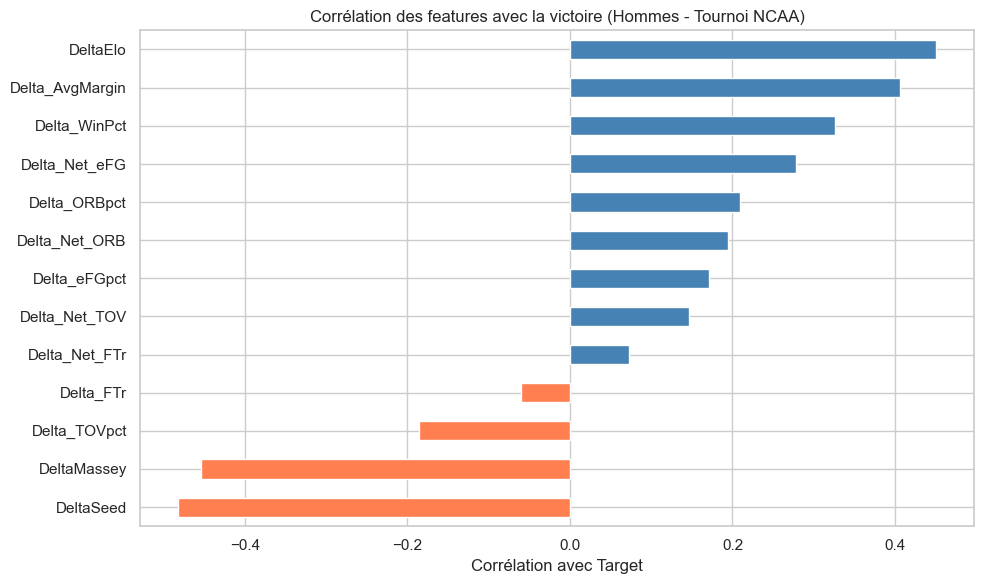

In [29]:
# =============================================================
# Définir les features pour chaque genre
# =============================================================

DELTA_STAT_FEATURES = [
    'Delta_WinPct', 'Delta_AvgMargin',
    'Delta_eFGpct', 'Delta_TOVpct', 'Delta_ORBpct', 'Delta_FTr',
    'Delta_Net_eFG', 'Delta_Net_TOV', 'Delta_Net_ORB', 'Delta_Net_FTr',
]

M_FEATURES = ['DeltaSeed', 'DeltaElo', 'DeltaMassey'] + DELTA_STAT_FEATURES
W_FEATURES = ['DeltaSeed', 'DeltaElo'] + DELTA_STAT_FEATURES

# Nettoyage : supprimer les lignes avec trop de NaN
m_train_clean = m_train.dropna(subset=M_FEATURES + ['Target'])
w_train_clean = w_train.dropna(subset=W_FEATURES + ['Target'])

print(f'Hommes après nettoyage : {len(m_train_clean):,} matchs ({len(m_train) - len(m_train_clean)} supprimés)')
print(f'Femmes après nettoyage : {len(w_train_clean):,} matchs ({len(w_train) - len(w_train_clean)} supprimés)')

# Corrélation des features avec la cible (Hommes)
corr = m_train_clean[M_FEATURES + ['Target']].corr()['Target'].drop('Target').sort_values()
fig, ax = plt.subplots(figsize=(10, 6))
corr.plot(kind='barh', ax=ax, color=['coral' if v < 0 else 'steelblue' for v in corr.values])
ax.set_title('Corrélation des features avec la victoire (Hommes - Tournoi NCAA)')
ax.set_xlabel('Corrélation avec Target')
plt.tight_layout()
plt.show()

---
## 4. Modèle Baseline : Régression Logistique

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.preprocessing import StandardScaler

def temporal_cv_evaluate(df, features, target_col='Target', min_train_seasons=10):
    """
    Validation croisée temporelle : entraîner sur les saisons passées, valider sur la suivante.
    Retourne les prédictions out-of-fold et le Brier score moyen.
    """
    seasons = sorted(df['Season'].unique())
    all_preds = []
    all_targets = []
    brier_scores = []
    
    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]
        
        train_mask = df['Season'].isin(train_seasons)
        val_mask = df['Season'] == val_season
        
        if val_mask.sum() == 0:
            continue
        
        X_train = df.loc[train_mask, features].values
        y_train = df.loc[train_mask, target_col].values
        X_val = df.loc[val_mask, features].values
        y_val = df.loc[val_mask, target_col].values
        
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_val_s = scaler.transform(X_val)
        
        lr = LogisticRegression(C=1.0, max_iter=1000)
        lr.fit(X_train_s, y_train)
        preds = lr.predict_proba(X_val_s)[:, 1]
        
        bs = brier_score_loss(y_val, preds)
        brier_scores.append((val_season, bs, len(y_val)))
        all_preds.extend(preds)
        all_targets.extend(y_val)
    
    overall_brier = brier_score_loss(all_targets, all_preds)
    return overall_brier, brier_scores

# Évaluation Baseline Hommes
print('=== BASELINE RÉGRESSION LOGISTIQUE ===')
print('\n--- Hommes ---')
m_brier, m_details = temporal_cv_evaluate(m_train_clean, M_FEATURES)
print(f'Brier Score global (CV temporelle) : {m_brier:.4f}')
for season, bs, n in m_details[-5:]:
    print(f'  Saison {season} : Brier = {bs:.4f} ({n} matchs)')

print('\n--- Femmes ---')
w_brier, w_details = temporal_cv_evaluate(w_train_clean, W_FEATURES)
print(f'Brier Score global (CV temporelle) : {w_brier:.4f}')
for season, bs, n in w_details[-5:]:
    print(f'  Saison {season} : Brier = {bs:.4f} ({n} matchs)')

=== BASELINE RÉGRESSION LOGISTIQUE ===

--- Hommes ---
Brier Score global (CV temporelle) : 0.1941
  Saison 2021 : Brier = 0.2149 (66 matchs)
  Saison 2022 : Brier = 0.2306 (67 matchs)
  Saison 2023 : Brier = 0.2219 (67 matchs)
  Saison 2024 : Brier = 0.2014 (67 matchs)
  Saison 2025 : Brier = 0.1551 (67 matchs)

--- Femmes ---
Brier Score global (CV temporelle) : 0.1423
  Saison 2021 : Brier = 0.1478 (63 matchs)
  Saison 2022 : Brier = 0.1641 (67 matchs)
  Saison 2023 : Brier = 0.1618 (67 matchs)
  Saison 2024 : Brier = 0.1341 (67 matchs)
  Saison 2025 : Brier = 0.1042 (67 matchs)


---
## 5. Modèle Principal : XGBoost

In [ ]:
import xgboost as xgb
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def temporal_cv_xgb(df, features, params, target_col='Target', min_train_seasons=10):
    """CV temporelle pour XGBoost, retourne le Brier score."""
    seasons = sorted(df['Season'].unique())
    all_preds, all_targets = [], []
    
    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]
        
        train_mask = df['Season'].isin(train_seasons)
        val_mask = df['Season'] == val_season
        if val_mask.sum() == 0:
            continue
        
        X_train = df.loc[train_mask, features].values
        y_train = df.loc[train_mask, target_col].values
        X_val = df.loc[val_mask, features].values
        y_val = df.loc[val_mask, target_col].values
        
        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
        dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
        
        model = xgb.train(
            params, dtrain, num_boost_round=500,
            evals=[(dval, 'val')],
            early_stopping_rounds=50, verbose_eval=False
        )
        preds = model.predict(dval)
        all_preds.extend(preds)
        all_targets.extend(y_val)
    
    return brier_score_loss(all_targets, all_preds)

# Optimisation Optuna pour les hommes
def objective_m(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'verbosity': 0,
    }
    return temporal_cv_xgb(m_train_clean, M_FEATURES, params)

print('Optimisation XGBoost Hommes avec Optuna (20 essais)...')
study_m = optuna.create_study(direction='minimize')
study_m.optimize(objective_m, n_trials=20, show_progress_bar=True)

print(f'\nMeilleur Brier Score Hommes (XGBoost) : {study_m.best_value:.4f}')
print(f'Meilleurs paramètres : {study_m.best_params}')

In [ ]:
# Optimisation Optuna pour les femmes
def objective_w(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'verbosity': 0,
    }
    return temporal_cv_xgb(w_train_clean, W_FEATURES, params)

print('Optimisation XGBoost Femmes avec Optuna (50 essais)...')
study_w = optuna.create_study(direction='minimize')
study_w.optimize(objective_w, n_trials=50, show_progress_bar=True)

print(f'\nMeilleur Brier Score Femmes (XGBoost) : {study_w.best_value:.4f}')
print(f'Meilleurs paramètres : {study_w.best_params}')

In [ ]:
# Optimisation Optuna pour les femmes
def objective_w(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'verbosity': 0,
    }
    return temporal_cv_xgb(w_train_clean, W_FEATURES, params)

print('Optimisation XGBoost Femmes avec Optuna (20 essais)...')
study_w = optuna.create_study(direction='minimize')
study_w.optimize(objective_w, n_trials=20, show_progress_bar=True)

print(f'\nMeilleur Brier Score Femmes (XGBoost) : {study_w.best_value:.4f}')
print(f'Meilleurs paramètres : {study_w.best_params}')

# Feature importance (Hommes) + définition des best params
best_params_m = {**study_m.best_params, 'objective': 'binary:logistic', 'eval_metric': 'rmse', 'verbosity': 0}
best_params_w = {**study_w.best_params, 'objective': 'binary:logistic', 'eval_metric': 'rmse', 'verbosity': 0}

print(f'best_params_m = {best_params_m}')
print(f'best_params_w = {best_params_w}')

# Entraîner sur tout le dataset hommes pour voir les features
dtrain_m = xgb.DMatrix(m_train_clean[M_FEATURES].values, label=m_train_clean['Target'].values, feature_names=M_FEATURES)
model_m_full = xgb.train(best_params_m, dtrain_m, num_boost_round=300)

fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model_m_full, ax=ax, importance_type='gain', title='Feature Importance - XGBoost Hommes (gain)')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from scipy.optimize import minimize_scalar

def ensemble_cv(df, features, xgb_params, target_col='Target', min_train_seasons=10):
    """
    CV temporelle avec ensemble LR + XGBoost.
    Optimise le poids alpha de l'ensemble pour minimiser le Brier score.
    """
    seasons = sorted(df['Season'].unique())
    lr_preds_all, xgb_preds_all, targets_all, seasons_all = [], [], [], []
    
    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]
        
        train_mask = df['Season'].isin(train_seasons)
        val_mask = df['Season'] == val_season
        if val_mask.sum() == 0:
            continue
        
        X_train = df.loc[train_mask, features].values
        y_train = df.loc[train_mask, target_col].values
        X_val = df.loc[val_mask, features].values
        y_val = df.loc[val_mask, target_col].values
        
        # LR
        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_train)
        X_va_s = scaler.transform(X_val)
        lr = LogisticRegression(C=1.0, max_iter=1000)
        lr.fit(X_tr_s, y_train)
        lr_pred = lr.predict_proba(X_va_s)[:, 1]
        
        # XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
        dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
        model = xgb.train(xgb_params, dtrain, num_boost_round=500,
                          evals=[(dval, 'val')], early_stopping_rounds=50, verbose_eval=False)
        xgb_pred = model.predict(dval)
        
        lr_preds_all.extend(lr_pred)
        xgb_preds_all.extend(xgb_pred)
        targets_all.extend(y_val)
        seasons_all.extend([val_season] * len(y_val))
    
    lr_preds_all = np.array(lr_preds_all)
    xgb_preds_all = np.array(xgb_preds_all)
    targets_all = np.array(targets_all)
    
    # Optimiser le poids alpha
    def brier_for_alpha(alpha):
        ensemble_pred = alpha * lr_preds_all + (1 - alpha) * xgb_preds_all
        return brier_score_loss(targets_all, ensemble_pred)
    
    result = minimize_scalar(brier_for_alpha, bounds=(0, 1), method='bounded')
    best_alpha = result.x
    best_brier = result.fun
    
    # Comparaison
    brier_lr = brier_score_loss(targets_all, lr_preds_all)
    brier_xgb = brier_score_loss(targets_all, xgb_preds_all)
    
    return {
        'brier_lr': brier_lr,
        'brier_xgb': brier_xgb,
        'brier_ensemble': best_brier,
        'best_alpha': best_alpha,
    }

print('=== ENSEMBLE LR + XGBoost ===')
print('\n--- Hommes ---')
m_ensemble = ensemble_cv(m_train_clean, M_FEATURES, best_params_m)
print(f'  LR seul      : {m_ensemble["brier_lr"]:.4f}')
print(f'  XGBoost seul  : {m_ensemble["brier_xgb"]:.4f}')
print(f'  Ensemble      : {m_ensemble["brier_ensemble"]:.4f} (alpha LR = {m_ensemble["best_alpha"]:.2f})')

print('\n--- Femmes ---')
w_ensemble = ensemble_cv(w_train_clean, W_FEATURES, best_params_w)
print(f'  LR seul      : {w_ensemble["brier_lr"]:.4f}')
print(f'  XGBoost seul  : {w_ensemble["brier_xgb"]:.4f}')
print(f'  Ensemble      : {w_ensemble["brier_ensemble"]:.4f} (alpha LR = {w_ensemble["best_alpha"]:.2f})')

---
## 7. Génération des Soumissions

In [ ]:
# =============================================================
# Entraîner les modèles finaux sur TOUTES les données historiques
# =============================================================

def get_team_features(season, team_id, elo_dict, stats_df, seeds_df, massey_df=None):
    """Récupère toutes les features d'une équipe pour une saison donnée."""
    feats = {}
    
    # Seed
    seed = seeds_df.loc[(seeds_df['Season'] == season) & (seeds_df['TeamID'] == team_id), 'SeedNum']
    feats['Seed'] = seed.values[0] if len(seed) > 0 else 8.5  # Moyenne si pas de seed
    
    # Elo
    feats['Elo'] = elo_dict.get((season, team_id), 1500)
    
    # Stats
    stat_cols = ['WinPct', 'AvgMargin', 'eFGpct', 'TOVpct', 'ORBpct', 'FTr',
                 'Net_eFG', 'Net_TOV', 'Net_ORB', 'Net_FTr']
    for col in stat_cols:
        val = stats_df.loc[(stats_df['Season'] == season) & (stats_df['TeamID'] == team_id), col]
        feats[col] = val.values[0] if len(val) > 0 else np.nan
    
    # Massey
    if massey_df is not None:
        mc = massey_df.loc[(massey_df['Season'] == season) & (massey_df['TeamID'] == team_id), 'MasseyComposite']
        feats['Massey'] = mc.values[0] if len(mc) > 0 else np.nan
    
    return feats

def predict_submission(sub_df, elo_dict, stats_df, seeds_df, massey_df,
                       lr_model, lr_scaler, xgb_model, features, alpha,
                       has_massey=True, clip_low=0.02, clip_high=0.98):
    """
    Génère les prédictions pour un fichier de soumission.
    """
    predictions = []
    
    for _, row in sub_df.iterrows():
        parts = row['ID'].split('_')
        season = int(parts[0])
        team_a = int(parts[1])
        team_b = int(parts[2])
        
        feats_a = get_team_features(season, team_a, elo_dict, stats_df, seeds_df, massey_df if has_massey else None)
        feats_b = get_team_features(season, team_b, elo_dict, stats_df, seeds_df, massey_df if has_massey else None)
        
        # Construire les deltas
        delta = {}
        delta['DeltaSeed'] = feats_a['Seed'] - feats_b['Seed']
        delta['DeltaElo'] = feats_a['Elo'] - feats_b['Elo']
        if has_massey:
            delta['DeltaMassey'] = (feats_a.get('Massey', 175) or 175) - (feats_b.get('Massey', 175) or 175)
        
        stat_cols = ['WinPct', 'AvgMargin', 'eFGpct', 'TOVpct', 'ORBpct', 'FTr',
                     'Net_eFG', 'Net_TOV', 'Net_ORB', 'Net_FTr']
        for col in stat_cols:
            va = feats_a.get(col, 0) or 0
            vb = feats_b.get(col, 0) or 0
            delta[f'Delta_{col}'] = va - vb
        
        x = np.array([[delta[f] for f in features]])
        
        # Remplacer NaN par 0
        x = np.nan_to_num(x, nan=0.0)
        
        # LR
        lr_pred = lr_model.predict_proba(lr_scaler.transform(x))[:, 1][0]
        # XGBoost
        dmat = xgb.DMatrix(x, feature_names=features)
        xgb_pred = xgb_model.predict(dmat)[0]
        
        # Ensemble
        pred = alpha * lr_pred + (1 - alpha) * xgb_pred
        pred = np.clip(pred, clip_low, clip_high)
        
        predictions.append(pred)
    
    return predictions

print('Préparation des modèles finaux...')

In [ ]:
# =============================================================
# Fonctions VECTORISÉES pour la prédiction de soumission
# (remplacement de la boucle row-by-row par des merges pandas)
# =============================================================

def build_elo_df(elo_dict):
    """Convertit le dict Elo en DataFrame pour merge rapide."""
    records = [{'Season': k[0], 'TeamID': k[1], 'Elo': v} for k, v in elo_dict.items()]
    return pd.DataFrame(records)

m_elo_df = build_elo_df(m_elo)
w_elo_df = build_elo_df(w_elo)

def predict_submission_vectorized(sub_df, elo_df, stats_df, seeds_df, massey_df,
                                   lr_model, lr_scaler, xgb_model, features, alpha,
                                   has_massey=True, clip_low=0.02, clip_high=0.98):
    """
    Génère les prédictions avec des opérations vectorisées (merges).
    ~100x plus rapide que la version row-by-row.
    """
    # Parser les IDs
    df = sub_df[['ID']].copy()
    parts = df['ID'].str.split('_', expand=True)
    df['Season'] = parts[0].astype(int)
    df['TeamA'] = parts[1].astype(int)
    df['TeamB'] = parts[2].astype(int)
    
    # --- Merge Seeds ---
    df = df.merge(seeds_df.rename(columns={'TeamID': 'TeamA', 'SeedNum': 'SeedA'}),
                  on=['Season', 'TeamA'], how='left')
    df = df.merge(seeds_df.rename(columns={'TeamID': 'TeamB', 'SeedNum': 'SeedB'}),
                  on=['Season', 'TeamB'], how='left')
    df['SeedA'] = df['SeedA'].fillna(8.5)
    df['SeedB'] = df['SeedB'].fillna(8.5)
    
    # --- Merge Elo ---
    df = df.merge(elo_df.rename(columns={'TeamID': 'TeamA', 'Elo': 'EloA'}),
                  on=['Season', 'TeamA'], how='left')
    df = df.merge(elo_df.rename(columns={'TeamID': 'TeamB', 'Elo': 'EloB'}),
                  on=['Season', 'TeamB'], how='left')
    df['EloA'] = df['EloA'].fillna(1500)
    df['EloB'] = df['EloB'].fillna(1500)
    
    # --- Merge Stats ---
    stat_cols = ['WinPct', 'AvgMargin', 'eFGpct', 'TOVpct', 'ORBpct', 'FTr',
                 'Net_eFG', 'Net_TOV', 'Net_ORB', 'Net_FTr']
    
    stats_a = stats_df[['Season', 'TeamID'] + stat_cols].copy()
    stats_a.columns = ['Season', 'TeamA'] + [f'{c}_A' for c in stat_cols]
    df = df.merge(stats_a, on=['Season', 'TeamA'], how='left')
    
    stats_b = stats_df[['Season', 'TeamID'] + stat_cols].copy()
    stats_b.columns = ['Season', 'TeamB'] + [f'{c}_B' for c in stat_cols]
    df = df.merge(stats_b, on=['Season', 'TeamB'], how='left')
    
    # --- Merge Massey ---
    if has_massey and massey_df is not None:
        df = df.merge(massey_df.rename(columns={'TeamID': 'TeamA', 'MasseyComposite': 'MasseyA'}),
                      on=['Season', 'TeamA'], how='left')
        df = df.merge(massey_df.rename(columns={'TeamID': 'TeamB', 'MasseyComposite': 'MasseyB'}),
                      on=['Season', 'TeamB'], how='left')
        df['MasseyA'] = df['MasseyA'].fillna(175)
        df['MasseyB'] = df['MasseyB'].fillna(175)
    
    # --- Calculer les deltas ---
    df['DeltaSeed'] = df['SeedA'] - df['SeedB']
    df['DeltaElo'] = df['EloA'] - df['EloB']
    if has_massey and massey_df is not None:
        df['DeltaMassey'] = df['MasseyA'] - df['MasseyB']
    
    for col in stat_cols:
        df[f'Delta_{col}'] = df[f'{col}_A'].fillna(0) - df[f'{col}_B'].fillna(0)
    
    # --- Prédictions ---
    X = df[features].fillna(0).values
    
    # LR
    lr_preds = lr_model.predict_proba(lr_scaler.transform(X))[:, 1]
    
    # XGBoost
    dmat = xgb.DMatrix(X, feature_names=features)
    xgb_preds = xgb_model.predict(dmat)
    
    # Ensemble + clipping
    preds = alpha * lr_preds + (1 - alpha) * xgb_preds
    preds = np.clip(preds, clip_low, clip_high)
    
    return preds

print('Fonctions vectorisées prêtes.')

In [ ]:
# =============================================================
# Générer les prédictions Stage 1 (validation 2022-2025)
# =============================================================

# Séparer hommes et femmes dans la soumission
sub_stage1['TeamA'] = sub_stage1['ID'].apply(lambda x: int(x.split('_')[1]))
sub_stage1['TeamB'] = sub_stage1['ID'].apply(lambda x: int(x.split('_')[2]))
sub_stage1_m = sub_stage1[sub_stage1['TeamA'] < 3000].copy()
sub_stage1_w = sub_stage1[sub_stage1['TeamA'] >= 3000].copy()

print(f'Stage 1 : {len(sub_stage1_m):,} paires hommes, {len(sub_stage1_w):,} paires femmes')

print('\nGénération des prédictions hommes Stage 1...')
preds_m_s1 = predict_submission(
    sub_stage1_m, m_elo, m_stats, m_seeds_clean, m_massey_composite,
    lr_m_final, scaler_m, xgb_m_final, M_FEATURES, alpha_m, has_massey=True
)
sub_stage1_m['Pred'] = preds_m_s1
print(f'  -> {len(preds_m_s1):,} prédictions générées')

print('Génération des prédictions femmes Stage 1...')
preds_w_s1 = predict_submission(
    sub_stage1_w, w_elo, w_stats, w_seeds_clean, None,
    lr_w_final, scaler_w, xgb_w_final, W_FEATURES, alpha_w, has_massey=False
)
sub_stage1_w['Pred'] = preds_w_s1
print(f'  -> {len(preds_w_s1):,} prédictions générées')

# Combiner et sauvegarder
submission_s1 = pd.concat([sub_stage1_m[['ID', 'Pred']], sub_stage1_w[['ID', 'Pred']]])
submission_s1.to_csv('submission_stage1.csv', index=False)
print(f'\nFichier submission_stage1.csv sauvegardé ({len(submission_s1):,} lignes)')
print(f'Distribution des prédictions :')
print(submission_s1['Pred'].describe())

In [ ]:
# =============================================================
# Générer les prédictions Stage 1 (validation 2022-2025) — VECTORISÉ
# =============================================================

# Séparer hommes et femmes
sub_stage1['TeamA_id'] = sub_stage1['ID'].apply(lambda x: int(x.split('_')[1]))
sub_stage1_m = sub_stage1[sub_stage1['TeamA_id'] < 3000].copy()
sub_stage1_w = sub_stage1[sub_stage1['TeamA_id'] >= 3000].copy()

print(f'Stage 1 : {len(sub_stage1_m):,} paires hommes, {len(sub_stage1_w):,} paires femmes')

print('\nPrédictions hommes Stage 1...')
sub_stage1_m['Pred'] = predict_submission_vectorized(
    sub_stage1_m, m_elo_df, m_stats, m_seeds_clean, m_massey_composite,
    lr_m_final, scaler_m, xgb_m_final, M_FEATURES, alpha_m, has_massey=True
)

print('Prédictions femmes Stage 1...')
sub_stage1_w['Pred'] = predict_submission_vectorized(
    sub_stage1_w, w_elo_df, w_stats, w_seeds_clean, None,
    lr_w_final, scaler_w, xgb_w_final, W_FEATURES, alpha_w, has_massey=False
)

# Combiner et sauvegarder
submission_s1 = pd.concat([sub_stage1_m[['ID', 'Pred']], sub_stage1_w[['ID', 'Pred']]])
submission_s1.to_csv('submission_stage1.csv', index=False)
print(f'\nsubmission_stage1.csv sauvegardé ({len(submission_s1):,} lignes)')
print(submission_s1['Pred'].describe())

In [ ]:
# =============================================================
# Générer les prédictions Stage 2 (tournoi 2026) — VECTORISÉ
# =============================================================

sub_stage2['TeamA_id'] = sub_stage2['ID'].apply(lambda x: int(x.split('_')[1]))
sub_stage2_m = sub_stage2[sub_stage2['TeamA_id'] < 3000].copy()
sub_stage2_w = sub_stage2[sub_stage2['TeamA_id'] >= 3000].copy()

print(f'Stage 2 : {len(sub_stage2_m):,} paires hommes, {len(sub_stage2_w):,} paires femmes')

print('\nPrédictions hommes Stage 2...')
sub_stage2_m['Pred'] = predict_submission_vectorized(
    sub_stage2_m, m_elo_df, m_stats, m_seeds_clean, m_massey_composite,
    lr_m_final, scaler_m, xgb_m_final, M_FEATURES, alpha_m, has_massey=True
)

print('Prédictions femmes Stage 2...')
sub_stage2_w['Pred'] = predict_submission_vectorized(
    sub_stage2_w, w_elo_df, w_stats, w_seeds_clean, None,
    lr_w_final, scaler_w, xgb_w_final, W_FEATURES, alpha_w, has_massey=False
)

# Combiner et sauvegarder
submission_s2 = pd.concat([sub_stage2_m[['ID', 'Pred']], sub_stage2_w[['ID', 'Pred']]])
submission_s2.to_csv('submission_stage2.csv', index=False)
print(f'\nsubmission_stage2.csv sauvegardé ({len(submission_s2):,} lignes)')
print(submission_s2['Pred'].describe())